In [ ]:
#!pip install langchain
!pip install --upgrade --quiet  langchain-openai langchain_community tiktoken chromadb langchain
!pip install --upgrade --quiet  youtube-transcript-api
!pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j
!pip install pytube
!pip install langchain-chroma
!pip install streamlit-agraph

!pip install plotly



In [202]:
!pip install networkx

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 660.6 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.6 MB 656.4 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.6 MB 1.6 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.6 MB 2.5 MB/s eta 0:00:01
   -------------------------- ------------- 1.1/1.6 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 6.6 MB/s eta 0:00:00


In [4]:

import os

import networkx as nx



from langchain.chains.summarize import load_summarize_chain
from langchain_openai import ChatOpenAI
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.document_loaders import YoutubeLoader
from langchain_community.document_loaders.youtube import TranscriptFormat
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate


from dotenv import load_dotenv

from io import StringIO
import matplotlib.pyplot as plt

In [5]:
load_dotenv()


True

# Prompt Enginieering

In [6]:

loader = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=yJWAtr3kvPU&list=PLp-HxVRWl1QXQO55JNum2Oc0DpN-h1lF5",
    chunk_size_seconds=45,
    transcript_format=TranscriptFormat.CHUNKS,
    add_video_info=True,

)

transcript_documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=4000,
    chunk_overlap=1000,
    length_function=len,
    is_separator_regex=False,
)

In [7]:
video_title = transcript_documents[0].metadata['title']
video_url = transcript_documents[0].metadata['source']
video_author = transcript_documents[0].metadata['author']

In [8]:
# Create a StringIO object to hold the content in memory
memory_file = StringIO()

# Define the output file name
output_file = 'youtube_script.txt'
# Open the file in write mode

chunks = transcript_documents
with open(output_file, 'w') as file:
    # Iterate over each chunk in the list with an index to access the next chunk
    for i in range(len(chunks)):
        # Extract metadata and content from the current chunk
        title = chunks[i].metadata.get('title', 'Unknown Title')
        start_timestamp = chunks[i].metadata.get('start_timestamp', 'Unknown Timestamp')
        page_content = chunks[i].page_content

        # Determine the end timestamp
        if i + 1 < len(chunks):
            end_timestamp = chunks[i + 1].metadata.get('start_timestamp', 'Unknown Timestamp')
        else:
            end_timestamp = "End of Video"  # or some appropriate end marker

        title = chunks[i].metadata.get('title')
        # Prepare the content to write
        content = (
            f"Video Extract : {title}\n"
            f"[{start_timestamp}---->{end_timestamp}]:\n{page_content}\n"
            f"\n"
        )

        # Write the content to both the file and the StringIO object
        file.write(content)
        memory_file.write(content)

# Get the content from the StringIO object as a string
memory_content = memory_file.getvalue()

# Print confirmation message
print(f"Script written to {output_file}")

# You can use `memory_content` as needed, it's the full script content in memory
print(memory_content)


Script written to youtube_script.txt
Video Extract : Computer Vision for Football Analysis in Python with Yolov8 & OpenCV
[00:00:00---->00:00:45]:
hello everyone in this video I will show you how to use deep learning for football analysis based on game recordings so the main idea is to extract useful information from video recordings of football games and more precisely the ultimate goal is to track each object of Interest such as the players and the ball and to capture the coordinates of each tracked object at any given frame with relatively high accuracy and this would certainly allow us to calculate many useful statistics such as ball possession rate players traveled distances the ball and players average speed and many other statistics however as you can imagine there are many challenges that we need to overcome in order to achieve that goal so the

Video Extract : Computer Vision for Football Analysis in Python with Yolov8 & OpenCV
[00:00:45---->00:01:30]:
application we have toda

In [9]:

initial_chunk_prompt_template = """
Task: Here is a partial transcript of a youtube video with timestamps. Your task is to destile the information from  the raw transcript and write a concise well structure article that summarizes the
      new or intersting information. The timestamps where the information is being extracted should be added at the end. In case part or the whole of the video is a tutorial it is important to list the steps provided. 
      The reader might then go to the timestamps to check so include a chronological list or timeline summarizing the sequence of topics discussed in the video.
Part of Transcription:
{text}
PARTIAL ARTICLE:

[start_timestamp---->end_timestamp]"""



refine_chunk_template = """
We are working on processing the information from a long youtube transcript and destile it into one well structure cohesive text either a Medium Article or a scientific paper whatever fits best. The idea is that a reader with a technical backgroud
can easily read our composition and understand what new information/technology/insight is being presented in the video.

We are working by parts because the transcript it's a very big.
We have made a partial document up to a certain point of the transcript: {existing_answer}

Your job is to merge and maybe if appropiate summarize this partial articles together into a consice coherent document with an abstract, introduction, body paragraphs and conclusion

Requirements for the document:
Focus on what new knowledege is the video presenting. Explain what new or intersting, technologies,tool,algorithm,discovery, are being discussed and how do they work and why are they relevant

The document should have an abstract,introduction, and a paragraph for each key topic/tool/algorithm/etc.
The body paragraphs should  reference the timestamps of the transcript that support what they are saying as if they were citations.
The reader might then go to the timestamps to check so include a chronological list or timeline summarizing the sequence of topics discussed in the video

In case the video or part of the video is a tutorial list the steps provided.


Continue and refine the existing partial article with  more context below if appropiate in a way that is still coherent. Otherwise return the current partial article
------------
{text}
------------


PARTIALLY PROCESS DOCUMENT:"""

In [10]:
llm = ChatOpenAI(temperature=0.2,max_tokens=4096)

chunks = text_splitter.split_text(memory_content)
transcript_chunk_documents = text_splitter.create_documents(chunks)

for i,document in enumerate(transcript_chunk_documents):
    document.metadata.update({
        "video_title":transcript_documents[0].metadata['title'],
        "video_url":transcript_documents[0].metadata['source'],
        "video_author":transcript_documents[0].metadata['author']
    })
    

In [11]:

intial_prompt = PromptTemplate.from_template(initial_chunk_prompt_template)

refine_chunk_prompt = PromptTemplate.from_template(refine_chunk_template)

chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=intial_prompt,
    refine_prompt=refine_chunk_prompt,
    return_intermediate_steps=False,
    input_key="input_documents",
    output_key="output_text",
)
result = chain.invoke({"input_documents": transcript_chunk_documents}, return_only_outputs=False)



In [17]:

print(result['output_text'])

summary_content = result['output_text']

Abstract:
The video "Computer Vision for Football Analysis in Python with Yolov8 & OpenCV" delves into the application of deep learning and computer vision in football analysis, focusing on player, referee, and ball detection. This document aims to summarize the key technologies and tools discussed in the video, highlighting their relevance in enhancing football analysis.

Introduction:
The video introduces the concept of utilizing object detection models and tactical recordings for accurate player tracking and statistics calculation in football analysis. By leveraging technologies like Yolov8 and OpenCV, the application aims to provide valuable insights for coaches, analysts, and fans.

Body:
1. Detection of Players, Referees, and the Ball (00:02:15-00:03:00):
The video showcases the process of setting up team names, colors, and selecting frames for player detection. By using a tactical camera recording, the application accurately detects players and goalkeepers, emphasizing the impor

## Creating Knowledege Graph

In [18]:
from langchain_experimental.graph_transformers import LLMGraphTransformer


In [19]:
llm = ChatOpenAI(temperature=0.2,max_tokens=4096)


llm_transformer = LLMGraphTransformer(llm=llm)


text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=4000,
    chunk_overlap=1000,
    length_function=len,
    is_separator_regex=False,
)

In [20]:
processed_document =  result['output_text'] + '/n Transcript' + memory_content

chunks_processed = text_splitter.split_text(processed_document)

documents = text_splitter.create_documents(chunks_processed)



In [21]:
documents[0]

Document(page_content='Abstract:\nThe video "Computer Vision for Football Analysis in Python with Yolov8 & OpenCV" delves into the application of deep learning and computer vision in football analysis, focusing on player, referee, and ball detection. This document aims to summarize the key technologies and tools discussed in the video, highlighting their relevance in enhancing football analysis.\n\nIntroduction:\nThe video introduces the concept of utilizing object detection models and tactical recordings for accurate player tracking and statistics calculation in football analysis. By leveraging technologies like Yolov8 and OpenCV, the application aims to provide valuable insights for coaches, analysts, and fans.\n\nBody:\n1. Detection of Players, Referees, and the Ball (00:02:15-00:03:00):\nThe video showcases the process of setting up team names, colors, and selecting frames for player detection. By using a tactical camera recording, the application accurately detects players and goa

In [22]:
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Computer Vision', type='Technology'), Node(id='Football Analysis', type='Concept'), Node(id='Deep Learning', type='Technology'), Node(id='Yolov8', type='Tool'), Node(id='Opencv', type='Tool'), Node(id='Coaches', type='Person'), Node(id='Analysts', type='Person'), Node(id='Fans', type='Person'), Node(id='Object Detection Models', type='Technology'), Node(id='Tactical Recordings', type='Concept'), Node(id='Player Tracking', type='Concept'), Node(id='Statistics Calculation', type='Concept'), Node(id='Team Names', type='Concept'), Node(id='Colors', type='Concept'), Node(id='Frames', type='Concept'), Node(id='Tactical Camera Recording', type='Concept'), Node(id='Goalkeepers', type='Concept'), Node(id='Frame Selection', type='Concept'), Node(id='Color Customization', type='Concept'), Node(id='Model Hyperparameters', type='Concept'), Node(id='Detection Options', type='Concept'), Node(id='Web Application', type='Technology'), Node(id='Color Palettes', type='Concept'), Node(id='

In [23]:
from streamlit_agraph import Node, Edge

def create_streamlit_graph_elements(graph_documents):
    """
    Constructs lists of nodes and edges for a Streamlit graph from a list of graph documents.
    Ensures that nodes and edges are unique.

    Parameters:
    graph_documents (list): List of documents where each document contains nodes and relationships.

    Returns:
    tuple: A tuple containing two lists, one for nodes and one for edges.
    """
    unique_nodes = {}
    unique_edges = set()

    # Add nodes to the nodes list, avoiding duplicates
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id and str(node.id) not in unique_nodes:
                unique_nodes[str(node.id)] = Node(id=str(node.id), label=node.id, size=5, title=node.id)

    # Add edges to the edges list, avoiding duplicates
    for doc in graph_documents:
        for relationship in doc.relationships:
            if relationship.source and relationship.target:
                edge_tuple = (str(relationship.source.id), str(relationship.target.id), relationship.type)
                if edge_tuple not in unique_edges:
                    unique_edges.add(edge_tuple)

    # Convert sets and dicts to lists
    nodes = list(unique_nodes.values())
    edges = [Edge(source=edge[0], target=edge[1], type="CURVE_SMOOTH", label=edge[2]) for edge in unique_edges]

    return nodes, edges


In [24]:
nodes, edges = create_streamlit_graph_elements(graph_documents)


In [26]:
len(nodes)

297

## Connecting to the DB

In [69]:
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_openai import OpenAIEmbeddings
from langchain.chains import create_retrieval_chain
from langchain.chains import create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain

from langchain import hub
from langchain_core.messages import HumanMessage


In [70]:
# os.environ["NEO4J_URI"] = 'neo4j+s://dc95f850.databases.neo4j.io'
# os.environ["NEO4J_USERNAME"] = "neo4j"
# os.environ["NEO4J_PASSWORD"] = "zN5HB8pqpTWK8KNRSnkx-4Lzbwimem-AdH5UBL8pmTM"

graph = Neo4jGraph()

# Store to neo4j
graph.add_graph_documents(
  graph_documents, 
  baseEntityLabel=True, 
  include_source=True
)

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)
retriever = vector_index.as_retriever()

In [71]:
retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")
llm = ChatOpenAI(temperature=0.2, max_tokens=2048)
combine_docs_chain = create_stuff_documents_chain(llm, retrieval_qa_chat_prompt)


In [72]:
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)


Failed to write data to connection ResolvedIPv4Address(('34.66.78.163', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))
Failed to write data to connection IPv4Address(('dc95f850.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))


In [73]:
chat_history = []


In [74]:
question = "What is youtube video about?"
ai_msg_1 = retrieval_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg_1["answer"]])
print(ai_msg_1["answer"])

second_question = "How is CV done?"
ai_msg_2 = retrieval_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])


The YouTube video is about "Computer Vision for Football Analysis in Python with Yolov8 & OpenCV." It showcases the application of deep learning in football analysis, focusing on player and ball tracking. The video discusses challenges in tracking players and the ball accurately, setting team names and colors, selecting frames for detection, model hyperparameters, the algorithm for team prediction, homography transformation, and the annotation process for player detection and tactical map representation.
In the context provided, computer vision (CV) for football analysis is achieved using deep learning technologies like Yolov8 and OpenCV. The process involves training object detection models on custom datasets created from tactical map recordings of football games. The Yolov8 models are used to detect players, referees, the ball, and field key points in the input video. The detection results are then used for player tracking, team prediction, and tactical map representation. Additional

In [75]:
ai_msg_2

{'input': 'How is CV done?',
 'chat_history': [HumanMessage(content='What is youtube video about?'),
  'The YouTube video is about "Computer Vision for Football Analysis in Python with Yolov8 & OpenCV." It showcases the application of deep learning in football analysis, focusing on player and ball tracking. The video discusses challenges in tracking players and the ball accurately, setting team names and colors, selecting frames for detection, model hyperparameters, the algorithm for team prediction, homography transformation, and the annotation process for player detection and tactical map representation.'],
 'context': [Document(page_content="\ntext: Video Extract : Computer Vision for Football Analysis in Python with Yolov8 & OpenCV\n[00:00:45---->00:01:30]:\napplication we have today presents the first step and its main functionality is to detect the players the referee and the ball then seamlessly project their coordinates on a tactical map representation of the football field oka

## Visualize Knowledge Graphs

In [76]:

import seaborn as sns
import plotly.graph_objects as go
import networkx as nx
import numpy as np

sns.set_style('darkgrid')

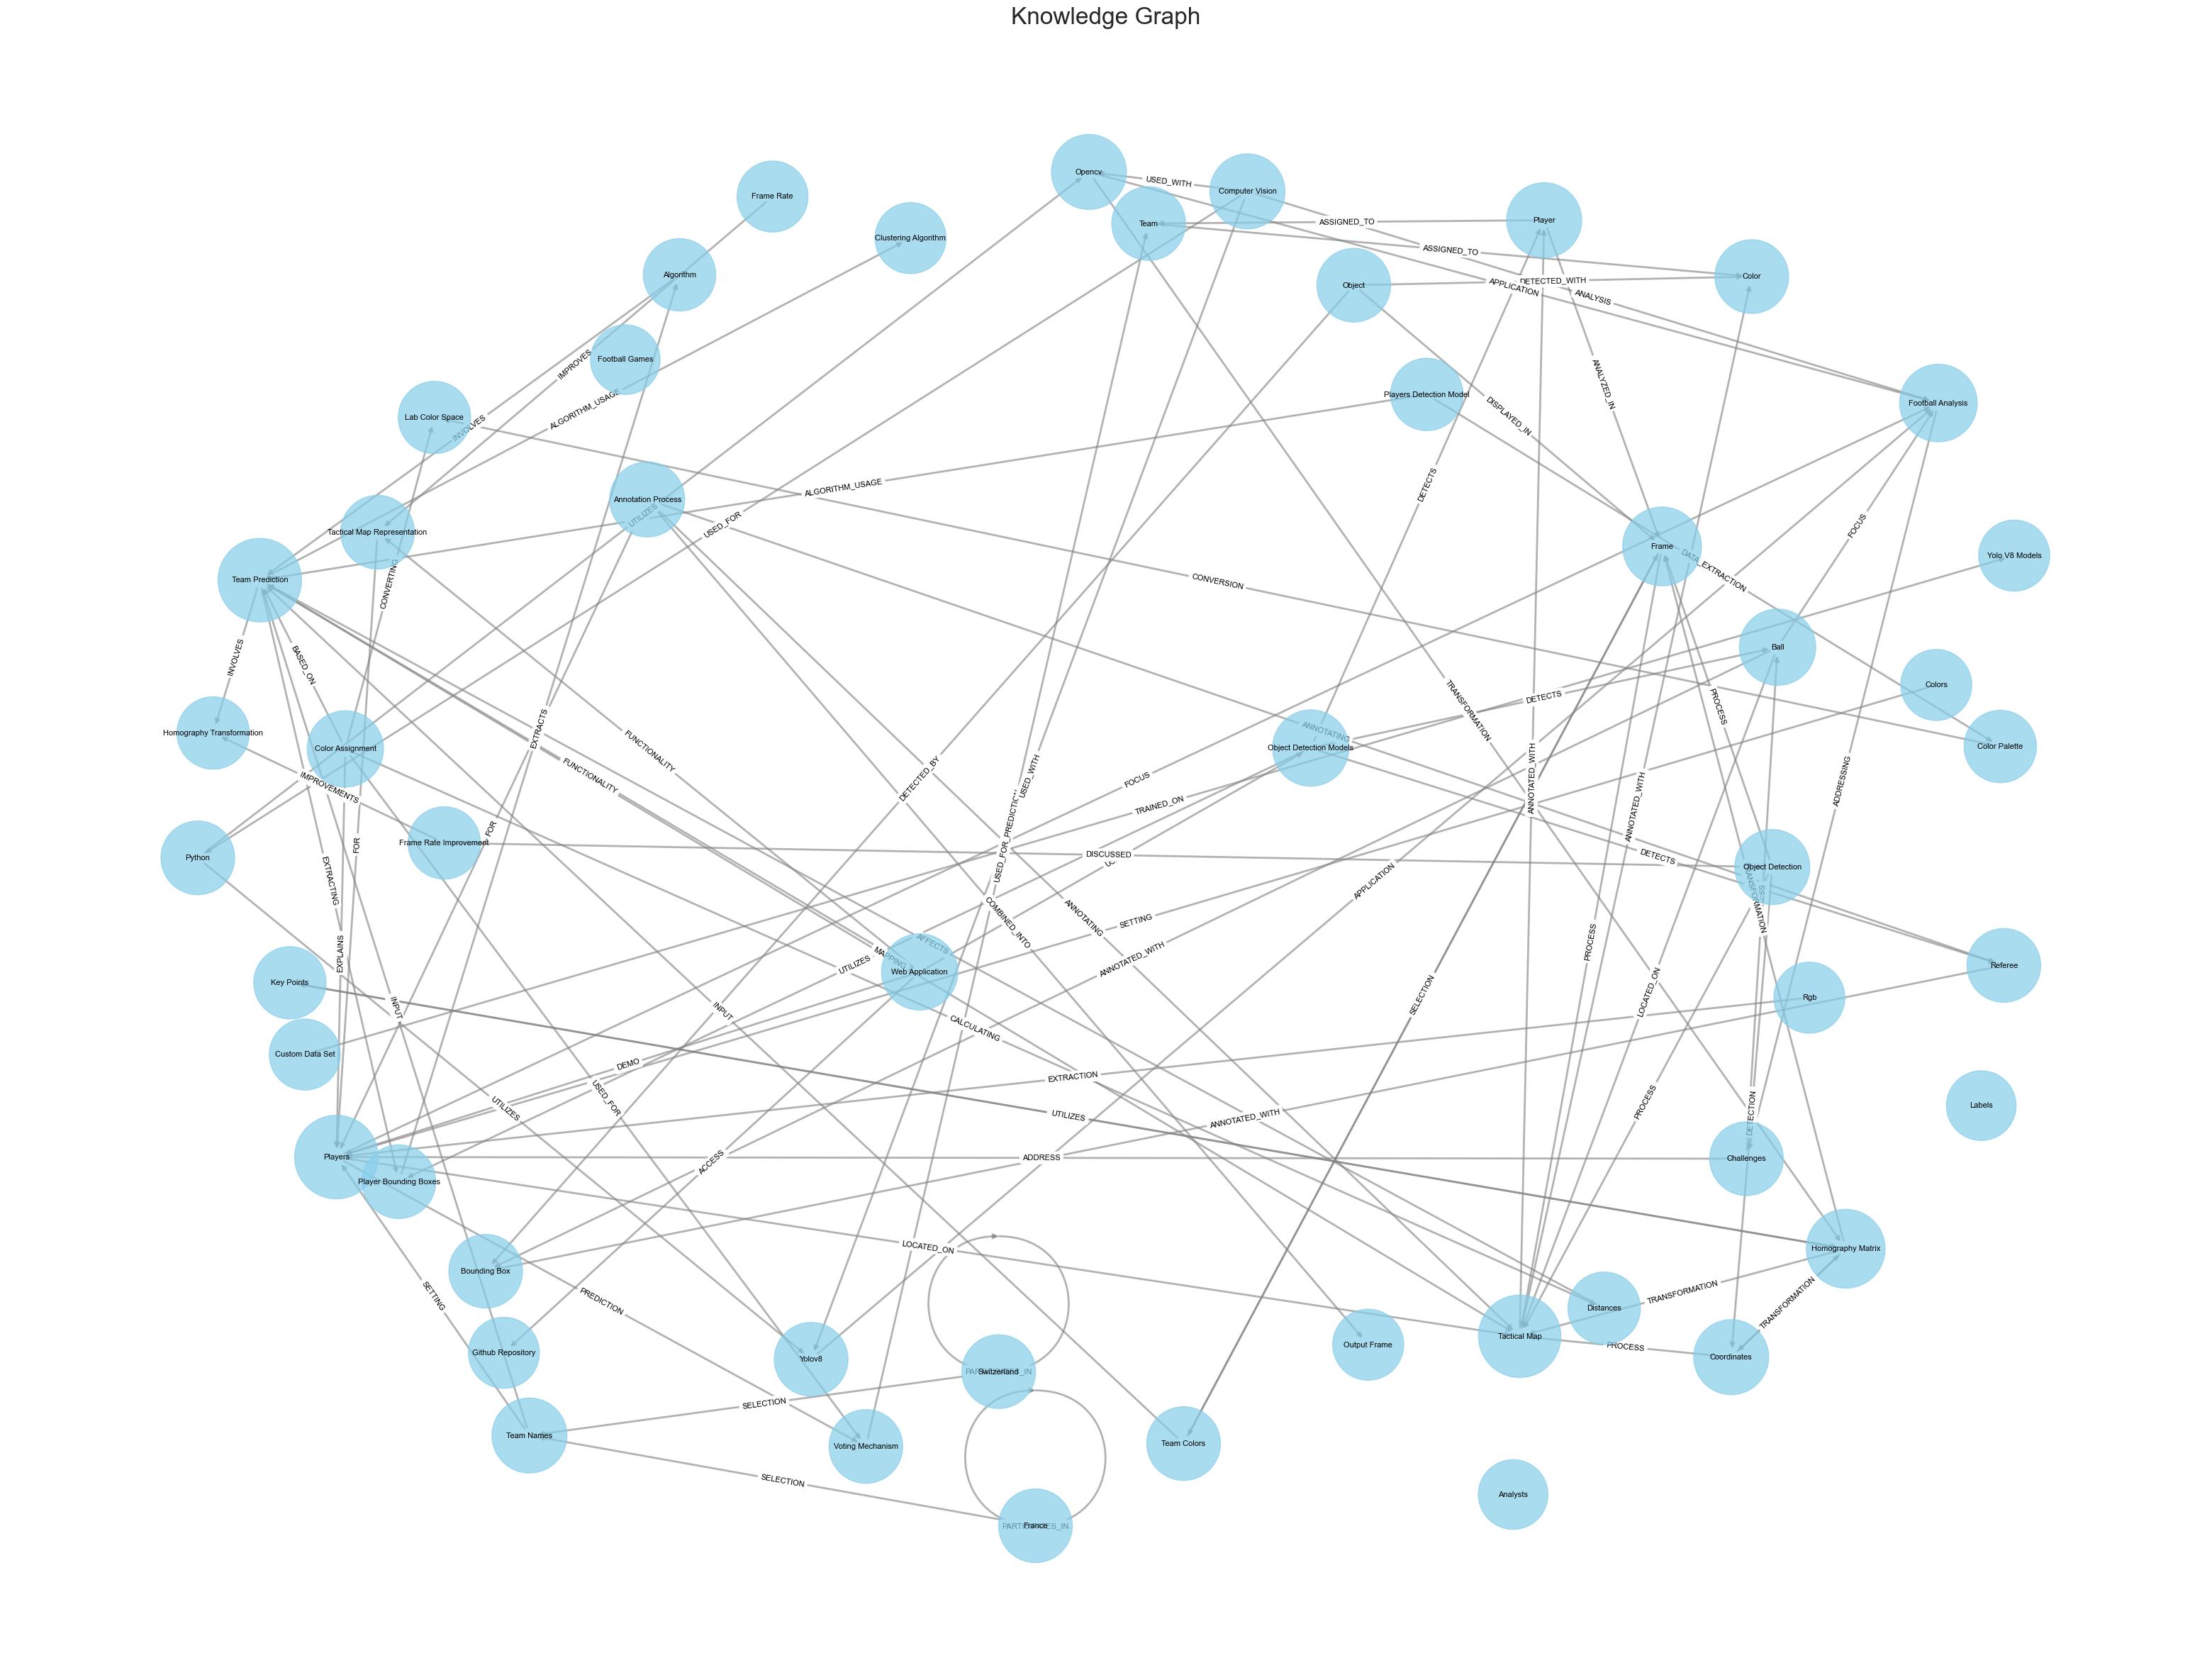

In [77]:


def create_networkx_graph(graph_documents):
    """
    Constructs a directed graph from a list of graph documents.
    
    Parameters:
    graph_documents (list): List of documents where each document contains nodes and relationships.

    Returns:
    nx.DiGraph: A directed graph with nodes and edges added from the documents.
    """
    G = nx.DiGraph()

    # Add nodes to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

    # Add edges to the graph
    for doc in graph_documents:
        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    return G

def get_top_nodes_by_degree(G, top_n=15):
    """
    Gets the top N nodes by degree (sum of in-degree and out-degree).

    Parameters:
    G (nx.DiGraph): A directed graph.
    top_n (int): Number of top nodes to return.

    Returns:
    list: List of top N nodes by degree.
    """
    degree_dict = dict(G.degree(G.nodes))
    sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)
    return sorted_nodes[:top_n]

def visualize_networkx_graph(G,top_n=50):
    """
    Visualizes a directed graph using Matplotlib.
    
    Parameters:
    G (nx.DiGraph): A directed graph to be visualized.
    """
    top_nodes = get_top_nodes_by_degree(G,top_n=top_n)
    subgraph = G.subgraph(top_nodes).copy()

    plt.figure(figsize=(40, 30))  # Increase figure size for better visibility

    # Compute positions for the nodes using the spring layout
    pos = nx.spring_layout(subgraph, k=1, iterations=25)  # Adjust k value for more natural spacing

    # Define node sizes based on their degree
    node_sizes = [5000 + 200 * subgraph.degree(node) for node in subgraph.nodes]
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

    # Create a dictionary of node labels
    node_labels = {node: subgraph.nodes[node].get('label', node) for node in subgraph.nodes}
    nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=8, font_family='sans-serif', font_color='black')

    # Draw edges with specific width and color
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), width=2, edge_color='gray', alpha=0.6)

    # Create a dictionary of edge labels
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8, font_family='sans-serif')

    plt.title("Knowledge Graph", fontsize=24)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
G = create_networkx_graph(graph_documents)
visualize_networkx_graph(G)


In [78]:
top_nodes = get_top_nodes_by_degree(G,top_n=25)


In [79]:
top_nodes

['Players',
 'Team Prediction',
 'Tactical Map',
 'Football Analysis',
 'Object Detection Models',
 'Homography Matrix',
 'Frame',
 'Ball',
 'Annotation Process',
 'Web Application',
 'Object Detection',
 'Color Palette',
 'Tactical Map Representation',
 'Color Assignment',
 'Frame Rate Improvement',
 'Coordinates',
 'Clustering Algorithm',
 'Labels',
 'Computer Vision',
 'Opencv',
 'Team Names',
 'Algorithm',
 'Homography Transformation',
 'Team Colors',
 'Player']

In [49]:

def create_networkx_graph(graph_documents):
    """
    Constructs a directed graph from a list of graph documents.
    
    Parameters:
    graph_documents (list): List of documents where each document contains nodes and relationships.

    Returns:
    nx.DiGraph: A directed graph with nodes and edges added from the documents.
    """
    G = nx.DiGraph()

    # Add nodes to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

    # Add edges to the graph
    for doc in graph_documents:
        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    return G

def get_top_nodes_by_degree(G, top_n=15):
    """
    Gets the top N nodes by degree (sum of in-degree and out-degree).

    Parameters:
    G (nx.DiGraph): A directed graph.
    top_n (int): Number of top nodes to return.

    Returns:
    list: List of top N nodes by degree.
    """
    degree_dict = dict(G.degree(G.nodes))
    sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)
    return sorted_nodes[:top_n]

def visualize_networkx_graph_3d(G,num_nodes=100):
    """
    Visualizes a directed graph in 3D using Plotly.
    
    Parameters:
    G (nx.DiGraph): A directed graph to be visualized.
    """
    top_nodes = get_top_nodes_by_degree(G,top_n=num_nodes)
    subgraph = G.subgraph(top_nodes).copy()

    # Generate 3D positions for the nodes using the spring layout
    pos = nx.spring_layout(subgraph, dim=3, k=0.8, iterations=50)

    # Extract and center node positions
    x_nodes = [pos[node][0] for node in subgraph.nodes]
    y_nodes = [pos[node][1] for node in subgraph.nodes]
    z_nodes = [pos[node][2] for node in subgraph.nodes]
    
    x_centered = [x - np.mean(x_nodes) for x in x_nodes]
    y_centered = [y - np.mean(y_nodes) for y in y_nodes]
    z_centered = [z - np.mean(z_nodes) for z in z_nodes]
    
    # Create edges
    edge_x = []
    edge_y = []
    edge_z = []
    edge_labels = []
    for edge in subgraph.edges:
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]
        edge_labels.append(subgraph.edges[edge].get('label', ''))
    
    # Remove None values and center edges
    edge_x = [x for x in edge_x if x is not None]
    edge_y = [y for y in edge_y if y is not None]
    edge_z = [z for z in edge_z if z is not None]
    
    edge_x_centered = [x - np.mean(x_nodes) for x in edge_x]
    edge_y_centered = [y - np.mean(y_nodes) for y in edge_y]
    edge_z_centered = [z - np.mean(z_nodes) for z in edge_z]
    
    # Determine node sizes based on degree
    node_degrees = dict(subgraph.degree())
    max_degree = max(node_degrees.values())
    node_sizes = [10 + 50 * (degree / max_degree) for _, degree in node_degrees.items()]

    # Create a trace for nodes with labels
    node_trace = go.Scatter3d(
        x=x_centered, y=y_centered, z=z_centered,
        mode='markers+text',
        marker=dict(size=node_sizes, color='skyblue', opacity=0.5),
        text=[subgraph.nodes[node].get('label', '') for node in subgraph.nodes],
        textposition='top center',
        textfont=dict(size=8, color='black')
    )
    
    # Create a trace for edges
    edge_trace = go.Scatter3d(
        x=edge_x_centered, y=edge_y_centered, z=edge_z_centered,
        mode='lines',
        line=dict(width=1, color='lightgray'),
        hoverinfo='none'
    )
    
    # Create a trace for edge labels
    edge_label_trace = go.Scatter3d(
        x=[(pos[edge[0]][0] + pos[edge[1]][0]) / 2 for edge in subgraph.edges],
        y=[(pos[edge[0]][1] + pos[edge[1]][1]) / 2 for edge in subgraph.edges],
        z=[(pos[edge[0]][2] + pos[edge[1]][2]) / 2 for edge in subgraph.edges],
        mode='text',
        text=edge_labels,
        textposition='middle center',
        textfont=dict(size=8, color='gray'),
        hoverinfo='none'
    )
    
    # Create the 3D plot
    fig = go.Figure(data=[edge_trace, edge_label_trace, node_trace],
                    layout=go.Layout(
                        title="3D Knowledge Graph",
                        titlefont_size=16,
                        showlegend=False,
                        scene=dict(
                            xaxis=dict(showbackground=False, showgrid=False, showticklabels=False, range=[-1, 1]),
                            yaxis=dict(showbackground=False, showgrid=False, showticklabels=False, range=[-1, 1]),
                            zaxis=dict(showbackground=False, showgrid=False, showticklabels=False, range=[-1, 1]),
                            camera=dict(
                                eye=dict(x=0, y=0, z=.4)  # Adjust this value to start the camera at the center
                            )
                        )
                    ))
    
    fig.show()

# Example usage
G = create_networkx_graph(graph_documents)
visualize_networkx_graph_3d(G)


## Creating a ChromaDB for RAG

In [47]:
from langchain_chroma import Chroma
from langchain.chains import create_retrieval_chain


In [17]:
embeddings = OpenAIEmbeddings()


In [48]:
summary_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=2000,
    chunk_overlap=1000,
    length_function=len,
    is_separator_regex=False,
)

chunks = summary_splitter.split_text(summary_content)

# Define metadata for summary content
metadata={'video_title':video_title,
          'doc_type':'summary',
          'video_url':video_url,
          'video_author':video_author}

summary_chunk_documents= summary_splitter.create_documents(chunks,[metadata for chunk in chunks])


In [49]:
embeddings = OpenAIEmbeddings()

# load it into Chroma
db = Chroma.from_documents(transcript_chunk_documents, embeddings,persist_directory="./chroma_db")

# query it
query = "What is the video about"
docs = db.similarity_search(query)

# print results
print(docs[0].page_content)



Video Extract : A Walkthrough of Progress Measures for Grokking via Mechanistic Interpretability: What? (Part 1/3)
[00:00:00---->00:00:45]:
it sounds like it's really put the most important bit at the really really start of the first video Welcome to a walkthrough of progress measures for grocking Via mechanistic interpretability which is this fun paper but I and lortz who has here to join me for involved in where we took models that corrupt things and then stared really hard inside of them and left with some vague understanding what the hell is going on and the goal of this is going to be to chat through what we did what on Earth is going on and what is interesting about this and why you might Care Lawrence gets a great deal of credit for being the only reason we actually wrote this paper up properly the other co-authors were Tom Librium because now

Video Extract : A Walkthrough of Progress Measures for Grokking via Mechanistic Interpretability: What? (Part 1/3)
[00:00:45---->00:01:3

In [ ]:
embeddings = OpenAIEmbeddings()

# load it into Chroma
db = Chroma.from_documents(transcript_chunk_documents+summary_chunk_documents, embeddings)

# query it
query = "What is the video about"
docs = db.similarity_search(query)

# print results
print(docs[0].page_content)



In [167]:
retriever = db.as_retriever()

In [152]:
print(docs[2].page_content)


19. Exploring geographical data visualization and external applications (00:30:45---->00:31:30):
The video showcases the visualization of airport data with geographical information, including city, region, and country details. Despite potential data inaccuracies, the visualization provides insights into the locations of airports and their connections.

20. Integration with external Data Explorer applications (00:31:30---->00:32:15):
Sebastian Müller introduces an integration with external Data Explorer applications for visualizing and exploring graph data in a different way. This integration allows for more sophisticated visualization options and exploration of data schema outside the scope of Jupyter Lab extension.

21. Advanced visualization options and map layout features (00:32:15---->00:33:45):
The integration with Data Explorer applications offers advanced styling options for elements, including icons and additional code, enhancing the end-user experience. The application also al

In [153]:
print(docs[3].page_content)


19. Exploring geographical data visualization and external applications (00:30:45---->00:31:30):
The video showcases the visualization of airport data with geographical information, including city, region, and country details. Despite potential data inaccuracies, the visualization provides insights into the locations of airports and their connections.

20. Integration with external Data Explorer applications (00:31:30---->00:32:15):
Sebastian Müller introduces an integration with external Data Explorer applications for visualizing and exploring graph data in a different way. This integration allows for more sophisticated visualization options and exploration of data schema outside the scope of Jupyter Lab extension.

21. Advanced visualization options and map layout features (00:32:15---->00:33:45):
The integration with Data Explorer applications offers advanced styling options for elements, including icons and additional code, enhancing the end-user experience. The application also al

## Create Conversational Chain

In [172]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

from langchain_core.messages import HumanMessage

contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.\

{context}"""

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)



retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")


In [178]:
!pip install langchainhub

In [180]:
from langchain import hub

retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")
combine_docs_chain = create_stuff_documents_chain(
    llm, retrieval_qa_chat_prompt
)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

question = "What is youtube video about?"
ai_msg_1 = retrieval_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg_1["answer"]])
print(ai_msg_1["answer"])

second_question = "what specific technologies are being discussed and how do we use them?"
ai_msg_2 = retrieval_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])


In [170]:

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)



In [173]:
chat_history = []

question = "What is youtube video about?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg_1["answer"]])

second_question = "tell me more?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})




The video delves into automating visualization tasks through literate programming in Jupyter Notebooks, enabling users to create custom visualizations for better data comprehension in graph databases. It also covers advanced features like dynamic color mapping, customizing labels for nodes, and changing the geometry of elements to enhance the visual representation of graph data. Additionally, the speaker plans to share specific notebook files on GitHub for public access and mentions potential Google CoLab support in upcoming versions by early 2023, aiming to expand accessibility and functionality for users.


In [175]:
print(ai_msg_1["answer"])


The YouTube video is about graph visualization using Jupyter Notebooks, showcasing tools like yFiles graphs, data explorer apps, and the Jupyter Notebook plugin for interactive exploration and analysis of graph data. It also discusses integrating Neo4j databases with Jupyter Notebooks to enhance data visualization capabilities and run graph data science algorithms effectively. The video provides insights into customizing visual elements, leveraging third-party packages, and utilizing graph data science algorithms for in-depth exploration and understanding of complex data structures.


In [174]:
print(ai_msg_2["answer"])


The video delves into automating visualization tasks through literate programming in Jupyter Notebooks, enabling users to create custom visualizations for better data comprehension in graph databases. It also covers advanced features like dynamic color mapping, customizing labels for nodes, and changing the geometry of elements to enhance the visual representation of graph data. Additionally, the speaker plans to share specific notebook files on GitHub for public access and mentions potential Google CoLab support in upcoming versions by early 2023, aiming to expand accessibility and functionality for users.
